## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve

# to persist the model and the scaler
import joblib

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
# ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']
vars_num = [var for var in data.columns if data[var].dtypes in ['int64', 'float64']]

# ['sex', 'cabin', 'embarked', 'title'] 
vars_cat = [var for var in data.columns if data[var].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables
num_vars_with_na = [var for var in vars_num if data[var].isnull().sum()>=1]

for var in num_vars_with_na:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')


age 0.201  % missing values
fare 0.001  % missing values


In [12]:
print('Zero values in Fare:', sum(data['fare'] == 0))

Zero values in Fare: 17


In [13]:
# now in categorical variables
cat_vars_with_na = [var for var in vars_cat if data[var].isnull().sum()>=1]

for var in cat_vars_with_na:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')


cabin 0.775  % missing values
embarked 0.002  % missing values


### Determine cardinality of categorical variables

In [14]:
for var in vars_cat:
    print(var, len(data[var].unique()), ' categories')

sex 2  categories
cabin 182  categories
embarked 4  categories
title 5  categories


### Determine the distribution of numerical variables

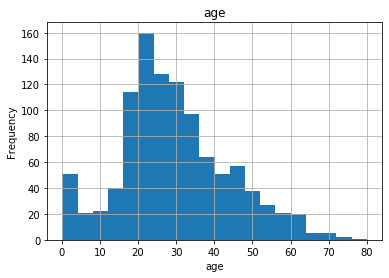

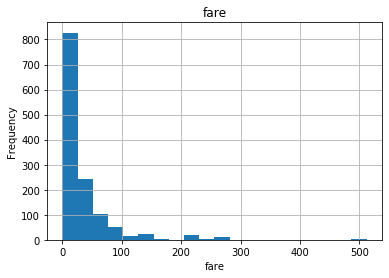

In [15]:
def analyse_continous(df, var):
    df = df.copy()
    df[var].hist(bins=20)
    plt.ylabel('Frequency')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

cont_vars = [var for var in data.columns if data[var].dtypes == 'float64']

for var in cont_vars:
    analyse_continous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [17]:
X_train[~X_train['cabin'].isnull()]

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
44,1,female,41.0,0,0,134.5000,E40,C,Miss
1217,3,male,19.0,0,0,7.6500,F,S,Mr
269,1,male,NaN,0,0,26.0000,A19,S,Mr
322,1,female,36.0,0,0,135.6333,C32,C,Miss
333,2,female,36.0,0,0,13.0000,D,S,Mrs
...,...,...,...,...,...,...,...,...,...
115,1,male,64.0,1,4,263.0000,C23,S,Mr
72,1,female,26.0,1,0,136.7792,C89,C,Mrs
174,1,male,58.0,0,0,29.7000,B37,C,Mr
314,1,female,50.0,1,1,211.5000,C80,C,Mrs


In [18]:
def get_cab_letter(cabin):
    try:
        return cabin[0]
    except TypeError:
        return cabin

X_train['cabin'] = X_train['cabin'].apply(get_cab_letter)

In [19]:
X_train[~X_train['cabin'].isnull()]

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
44,1,female,41.0,0,0,134.5000,E,C,Miss
1217,3,male,19.0,0,0,7.6500,F,S,Mr
269,1,male,NaN,0,0,26.0000,A,S,Mr
322,1,female,36.0,0,0,135.6333,C,C,Miss
333,2,female,36.0,0,0,13.0000,D,S,Mrs
...,...,...,...,...,...,...,...,...,...
115,1,male,64.0,1,4,263.0000,C,S,Mr
72,1,female,26.0,1,0,136.7792,C,C,Mrs
174,1,male,58.0,0,0,29.7000,B,C,Mr
314,1,female,50.0,1,1,211.5000,C,C,Mrs


In [20]:
X_test['cabin'] = X_test['cabin'].apply(get_cab_letter)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [21]:
median_age = np.nanmedian(X_train['age'])
median_age

28.0

In [22]:
# age 0.201  % missing values

# Train
has_nan = np.isnan(X_train['age'])
X_train['age_na'] = np.where(has_nan, 1, 0)
median_age = np.nanmedian(X_train['age'])
X_train['age'] = X_train['age'].fillna(median_age)

# Test
has_nan = np.isnan(X_test['age'])
X_test['age_na'] = np.where(has_nan, 1, 0)
X_test['age'] = X_test['age'].fillna(median_age)

X_train.head(2)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na
1118,3,male,25.0,0,0,7.925,NaN,S,Mr,0
44,1,female,41.0,0,0,134.500,E,C,Miss,0


In [23]:
# fare 0.001  % missing values
# Zero values in Fare: 17

zero_or_nan_fare = (X_train['fare'] == 0) | X_train['fare'].isna()
X_train.loc[:, 'fare_na'] = np.where(zero_or_nan_fare, 1, 0)

zero_or_nan_fare = (X_test['fare'] == 0) | X_test['fare'].isna()
X_test.loc[:, 'fare_na'] = np.where(zero_or_nan_fare, 1, 0)

median_fare_dict = dict(X_train.groupby('pclass')['fare'].median())
print('Median fares by passenger class:', median_fare_dict)

def replace_zero_fare(df, medians_dict):
    """Replace 0/nan values in Fare by median for the relevant pclass."""
    for pclass, median in medians_dict.items():
        zero_or_nan_condition = (df['fare'] == 0) | df['fare'].isna()
        condition = zero_or_nan_condition & (df['pclass'] == pclass)
        df.loc[condition, 'fare'] = median
        
        
print('Before in Train:', sum((X_train['fare'] == 0) | X_train['fare'].isna()))
replace_zero_fare(X_train, median_fare_dict)
print('After in Train', sum((X_train['fare'] == 0) | X_train['fare'].isna()))

print('Before in Test', sum((X_test['fare'] == 0) | X_test['fare'].isna()))
replace_zero_fare(X_test, median_fare_dict)
print('After in Test', sum((X_test['fare'] == 0) | X_test['fare'].isna()))

Median fares by passenger class: {1: 61.9792, 2: 13.93125, 3: 8.0292}
Before in Train: 16
After in Train 0
Before in Test 2
After in Test 0


### Replace Missing data in categorical variables with the string **Missing**

In [24]:
# cabin 0.775  % missing values
# embarked 0.002  % missing values

In [25]:
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = df[var_list].fillna('Missing')
    return X

vars_with_na = [var for var in vars_cat if data[var].isnull().sum()>=1]

# replace missing values with new label: "Missing"
X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

# check that we have no missing information in the engineered variables
print(X_train[vars_with_na].isnull().sum())
print(X_test[vars_with_na].isnull().sum())

cabin       0
embarked    0
dtype: int64
cabin       0
embarked    0
dtype: int64


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [26]:
# categorical variables list
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['sex', 'cabin', 'embarked', 'title']

In [27]:
pd.concat([X_train, y_train], axis=1)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,survived
1118,3,male,25.0000,0,0,7.9250,Missing,S,Mr,0,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0,1
1072,3,male,28.0000,0,0,7.7333,Missing,Q,Mr,1,0,0
1130,3,female,18.0000,0,0,7.7750,Missing,S,Miss,0,0,0
574,2,male,29.0000,1,0,21.0000,Missing,S,Mr,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,Missing,S,Miss,0,0,1
835,3,male,28.0000,0,0,8.0500,Missing,S,Mr,1,0,0
1216,3,female,28.0000,0,0,7.7333,Missing,Q,Miss,1,0,1
559,2,female,20.0000,0,0,36.7500,Missing,S,Miss,0,0,1


In [28]:
 pd.concat([X_train, y_train], axis=1).groupby('sex')['survived'].count()

sex
female    384
male      663
Name: survived, dtype: int64

In [29]:
def find_frequent_labels(df_x, df_y, var, rare_perc):
    # finds the labels that are shared by more than a certain % of passengers in the dataset
#     df = df.copy()
    tmp = pd.concat([df_x, df_y], axis=1).groupby(var)['survived'].count() / len(df_x)
    return tmp[tmp>rare_perc].index


frequent_labels_dict = {}

for var in cat_vars:
    frequent_ls = find_frequent_labels(X_train, y_train, var, 0.05)
    
    # save the list in a dictionary
    frequent_labels_dict[var] = frequent_ls
    
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')
    
# save the dictionary
np.save('FrequentLabels.npy', frequent_labels_dict)

In [30]:
frequent_labels_dict

{'sex': Index(['female', 'male'], dtype='object', name='sex'),
 'cabin': Index(['C', 'Missing'], dtype='object', name='cabin'),
 'embarked': Index(['C', 'Q', 'S'], dtype='object', name='embarked'),
 'title': Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')}

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [31]:
print(X_train.columns)
print(X_test.columns)

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title', 'age_na', 'fare_na'],
      dtype='object')
Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title', 'age_na', 'fare_na'],
      dtype='object')


In [32]:
X_train.head(2)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.925,Missing,S,Mr,0,0
44,1,female,41.0,0,0,134.500,Rare,C,Miss,0,0


In [33]:
X_test.head(2)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0


In [34]:
cat_vars

['sex', 'cabin', 'embarked', 'title']

In [35]:
X_train = pd.get_dummies(X_train)
print(X_train.columns)

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
       'sex_female', 'sex_male', 'cabin_C', 'cabin_Missing', 'cabin_Rare',
       'embarked_C', 'embarked_Q', 'embarked_Rare', 'embarked_S', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')


In [36]:
X_test = pd.get_dummies(X_test)

In [37]:
print(X_test.columns)

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
       'sex_female', 'sex_male', 'cabin_C', 'cabin_Missing', 'cabin_Rare',
       'embarked_C', 'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Rare'],
      dtype='object')


In [38]:
cols_to_keep = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
       'sex_female', 'cabin_C', 'cabin_Missing',
       'embarked_C', 'embarked_Q', 'embarked_S', 'title_Miss',
       'title_Mr', 'title_Mrs']

X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

### Taking Log of Fare

(array([559., 185.,  83.,  40.,  40.,  36.,  29.,   4.,  10.,   3.,  12.,
          9.,   3.,   0.,   0.,   0.,   8.,   9.,   0.,   3.,  12.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  3.1708 ,  15.89976,  28.62872,  41.35768,  54.08664,  66.8156 ,
         79.54456,  92.27352, 105.00248, 117.73144, 130.4604 , 143.18936,
        155.91832, 168.64728, 181.37624, 194.1052 , 206.83416, 219.56312,
        232.29208, 245.02104, 257.75   , 270.47896, 283.20792, 295.93688,
        308.66584, 321.3948 , 334.12376, 346.85272, 359.58168, 372.31064,
        385.0396 , 397.76856, 410.49752, 423.22648, 435.95544, 448.6844 ,
        461.41336, 474.14232, 486.87128, 499.60024, 512.3292 ]),
 <a list of 40 Patch objects>)

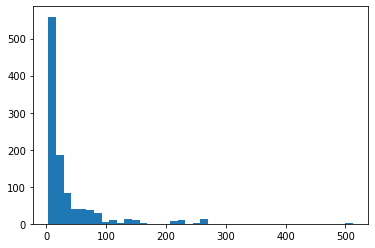

In [39]:
plt.hist(X_train['fare'], bins=40)

(array([150.,  58.,   7.,   8.,  11.,  13.,   2.,   0.,   4.,   0.,   1.,
          3.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  6.4375   ,  19.0847925,  31.732085 ,  44.3793775,  57.02667  ,
         69.6739625,  82.321255 ,  94.9685475, 107.61584  , 120.2631325,
        132.910425 , 145.5577175, 158.20501  , 170.8523025, 183.499595 ,
        196.1468875, 208.79418  , 221.4414725, 234.088765 , 246.7360575,
        259.38335  , 272.0306425, 284.677935 , 297.3252275, 309.97252  ,
        322.6198125, 335.267105 , 347.9143975, 360.56169  , 373.2089825,
        385.856275 , 398.5035675, 411.15086  , 423.7981525, 436.445445 ,
        449.0927375, 461.74003  , 474.3873225, 487.034615 , 499.6819075,
        512.3292   ]),
 <a list of 40 Patch objects>)

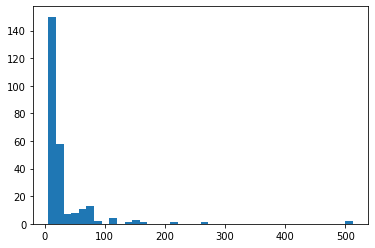

In [40]:
plt.hist(X_test['fare'], bins=40)

In [41]:
X_train.loc[:, 'fare'] = np.log(X_train.loc[:, 'fare'])
X_test.loc[:, 'fare'] = np.log(X_test.loc[:, 'fare'])

(array([  1.,   1.,   0.,   1.,   0.,   9.,  87., 260.,  24.,  35.,  20.,
         98.,  39.,  13.,  33.,  31.,  75.,  41.,  30.,  29.,   5.,  18.,
         38.,  19.,  20.,  34.,  15.,   8.,   5.,  12.,   9.,   3.,   0.,
         17.,  15.,   0.,   0.,   0.,   0.,   2.]),
 array([1.15398392, 1.28110851, 1.4082331 , 1.53535768, 1.66248227,
        1.78960686, 1.91673144, 2.04385603, 2.17098062, 2.2981052 ,
        2.42522979, 2.55235437, 2.67947896, 2.80660355, 2.93372813,
        3.06085272, 3.18797731, 3.31510189, 3.44222648, 3.56935107,
        3.69647565, 3.82360024, 3.95072483, 4.07784941, 4.204974  ,
        4.33209859, 4.45922317, 4.58634776, 4.71347235, 4.84059693,
        4.96772152, 5.09484611, 5.22197069, 5.34909528, 5.47621987,
        5.60334445, 5.73046904, 5.85759363, 5.98471821, 6.1118428 ,
        6.23896739]),
 <a list of 40 Patch objects>)

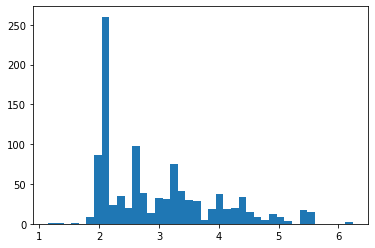

In [42]:
plt.hist(X_train['fare'], bins=40)

(array([ 5., 55., 26., 10., 10.,  3., 14., 16.,  9.,  2.,  7.,  5., 22.,
        13., 12.,  1.,  2.,  3.,  4.,  4.,  7.,  5., 11.,  2.,  1.,  0.,
         4.,  1.,  3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         2.]),
 array([1.86214027, 1.97156094, 2.08098162, 2.1904023 , 2.29982298,
        2.40924366, 2.51866433, 2.62808501, 2.73750569, 2.84692637,
        2.95634705, 3.06576772, 3.1751884 , 3.28460908, 3.39402976,
        3.50345044, 3.61287111, 3.72229179, 3.83171247, 3.94113315,
        4.05055383, 4.1599745 , 4.26939518, 4.37881586, 4.48823654,
        4.59765722, 4.70707789, 4.81649857, 4.92591925, 5.03533993,
        5.14476061, 5.25418128, 5.36360196, 5.47302264, 5.58244332,
        5.691864  , 5.80128468, 5.91070535, 6.02012603, 6.12954671,
        6.23896739]),
 <a list of 40 Patch objects>)

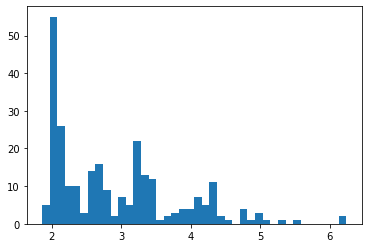

In [43]:
plt.hist(X_test['fare'], bins=40)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [44]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X_train[:1]

array([[ 0.83580798, -0.37016209, -0.47891102, -0.45542335, -0.92279555,
        -0.49492069, -0.12457493, -0.76104239, -0.28371704,  0.55123545,
        -0.4934247 , -0.31953914,  0.63964997, -0.50089526,  0.86989161,
        -0.43562912]])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [46]:
lr_clf = LogisticRegression(C=0.0005, random_state=0)

lr_clf.fit(X_train, y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [47]:
lr_pred = lr_clf.predict(X_test)

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       162
           1       1.00      0.25      0.40       100

    accuracy                           0.71       262
   macro avg       0.84      0.62      0.61       262
weighted avg       0.80      0.71      0.65       262



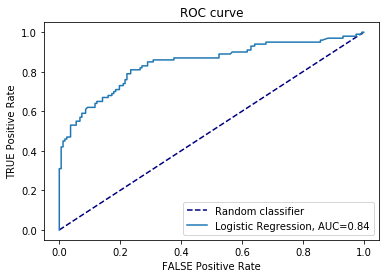

In [49]:
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test.astype(int), lr_pred_proba)
auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
# reference line for random classifier
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = 'Random classifier')
plt.plot(fpr_dt, tpr_dt, label='Logistic Regression, AUC={:.2f}'.format(auc_dt))
plt.xlabel('FALSE Positive Rate')
plt.ylabel('TRUE Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**